<a href="https://colab.research.google.com/github/hmezer/backtest-machine/blob/main/scripts/q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: get github repo

!git clone https://github.com/hmezer/backtest-machine

Cloning into 'backtest-machine'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 9), reused 22 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 1.09 MiB | 4.17 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [5]:
# read the pandas dataframe from CSV file
def read_dataframe_from_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

df = pd.read_csv("/content/backtest-machine/data/spx_data_with_features.csv", index_col=0)

# reset index to default integer index
df.reset_index(drop=True, inplace=True)

df.head()

,Close,High,Low,Open,Volume,Year,Month,Day,Weekday,Return,Log Return,Log Return Lag-1,Log Return Lag-2,Log Return Lag-5,Rolling Mean 5,Rolling Std 20,Rolling Skew 30,Rolling Kurt 30
0,1402.050049,1407.719971,1376.250000,1389.939941,1092100000,2000,2,15,1,0.008713,0.008675,0.002031,-0.021192,0.012198,-0.005580,0.013786,-0.625913,0.582261
1,1387.670044,1404.550049,1385.579956,1402.050049,1018800000,2000,2,16,2,-0.010256,-0.010309,0.008675,0.002031,-0.021035,-0.003435,0.013900,-0.285637,0.249951
2,1388.260010,1399.880005,1380.069946,1387.670044,1034800000,2000,2,17,3,0.000425,0.000425,-0.010309,0.008675,0.003620,-0.004074,0.013867,-0.274113,0.251292
3,1346.089966,1388.589966,1345.319946,1388.260010,1042300000,2000,2,18,4,-0.030376,-0.030847,0.000425,-0.010309,-0.021192,-0.006005,0.015295,-0.329597,-0.034608
4,1352.170044,1358.109985,1331.880005,1346.089966,980000000,2000,2,22,1,0.004517,0.004507,-0.030847,0.000425,0.002031,-0.005510,0.014234,-0.562546,0.035657


In [6]:
def create_windowed_dataset(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X.iloc[i:(i + window_size)].values)
        ys.append(y.iloc[i + window_size])
    return np.array(Xs), np.array(ys)

features = ['feature1', 'feature2', 'feature3']  # replace with your feature names

X = df[df.columns]  # all columns with your engineered features
df["Log Returns Future 1D"] = df["Log Return"].shift(-1)   # e.g. log_return shifted by -1
y = df["Log Returns Future 1D"]  # target variable
X_seq, y_seq = create_windowed_dataset(X, y, window_size=10)

X_seq.shape, y_seq.shape

((6249, 10, 18), (6249,))

In [7]:
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4999, 10, 18), (1250, 10, 18), (4999,), (1250,))

In [8]:
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)

X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

X_train_flat.shape, X_train_scaled.shape, X_test_flat.shape, X_test_scaled.shape

((49990, 18), (4999, 10, 18), (12500, 18), (1250, 10, 18))

***

In [13]:
df['Target 1D'] = df['Log Return'].shift(-1)
df['Target 5D'] = df['Log Return'].rolling(5).sum().shift(-5)
df['Target 20D'] = df['Log Return'].rolling(20).sum().shift(-20)
df['Target 250D'] = df['Log Return'].rolling(250).sum().shift(-250)

df.head()

,Close,High,Low,Open,Volume,Year,Month,Day,Weekday,Return,...,Log Return Lag-5,Rolling Mean 5,Rolling Std 20,Rolling Skew 30,Rolling Kurt 30,Log Returns Future 1D,Target 1D,Target 5D,Target 20D,Target 250D
0,1402.050049,1407.719971,1376.250000,1389.939941,1092100000,2000,2,15,1,0.008713,...,0.012198,-0.005580,0.013786,-0.625913,0.582261,-0.010309,-0.010309,-0.029944,-0.007093,-0.052523
1,1387.670044,1404.550049,1385.579956,1402.050049,1018800000,2000,2,16,2,-0.010256,...,-0.021035,-0.003435,0.013900,-0.285637,0.249951,0.000425,0.000425,-0.024984,0.049762,-0.050904
2,1388.260010,1399.880005,1380.069946,1387.670044,1034800000,2000,2,17,3,0.000425,...,0.003620,-0.004074,0.013867,-0.274113,0.251292,-0.030847,-0.030847,-0.040349,0.053442,-0.053515
3,1346.089966,1388.589966,1345.319946,1388.260010,1042300000,2000,2,18,4,-0.030376,...,-0.021192,-0.006005,0.015295,-0.329597,-0.034608,0.004507,0.004507,0.001455,0.078921,-0.014577
4,1352.170044,1358.109985,1331.880005,1346.089966,980000000,2000,2,22,1,0.004517,...,0.002031,-0.005510,0.014234,-0.562546,0.035657,0.006281,0.006281,0.010483,0.099659,-0.038170


***

#### Q4

In [ ]:
def walk_forward_split(X, y, initial_train_size, test_size, step_size, expanding=True):
    splits = []
    train_start = 0
    train_end = initial_train_size

    while train_end + test_size <= len(X):
        test_start = train_end
        test_end = train_end + test_size

        X_train = X[train_start:train_end]
        y_train = y[train_start:train_end]
        X_test = X[test_start:test_end]
        y_test = y[test_start:test_end]

        splits.append(((X_train, y_train), (X_test, y_test)))

        train_end += step_size
        if not expanding:
            train_start += step_size  # rolling window

    return splits

In [21]:
low, high, open, close = 10, 22, 10, 22

score_open = (open - low) / (high - low)
score_close = (close - low) / (high - low)

print(score_open, score_close)

0.0 1.0


In [22]:
# center around 0
score_open = score_open - 0.5
score_close = score_close - 0.5

print(score_open, score_close)

-0.5 0.5


In [25]:
df['Open Score'] = (df['Open'] - df['Low']) / (df['High'] - df['Low'])
df['Close Score'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

# Center the scores around 0
df['Open Score'] = df['Open Score'] - 0.5
df['Close Score'] = df['Close Score'] - 0.5

df[['Open', 'Close', 'Low', 'High', 'Open Score', 'Close Score']].head()

,Open,Close,Low,High,Open Score,Close Score
0,1389.939941,1402.050049,1376.250000,1407.719971,-0.064984,0.319831
1,1402.050049,1387.670044,1385.579956,1404.550049,0.368214,-0.389822
2,1387.670044,1388.260010,1380.069946,1399.880005,-0.116352,-0.086570
3,1388.260010,1346.089966,1345.319946,1388.589966,0.492374,-0.482204
4,1346.089966,1352.170044,1331.880005,1358.109985,0.041745,0.273544


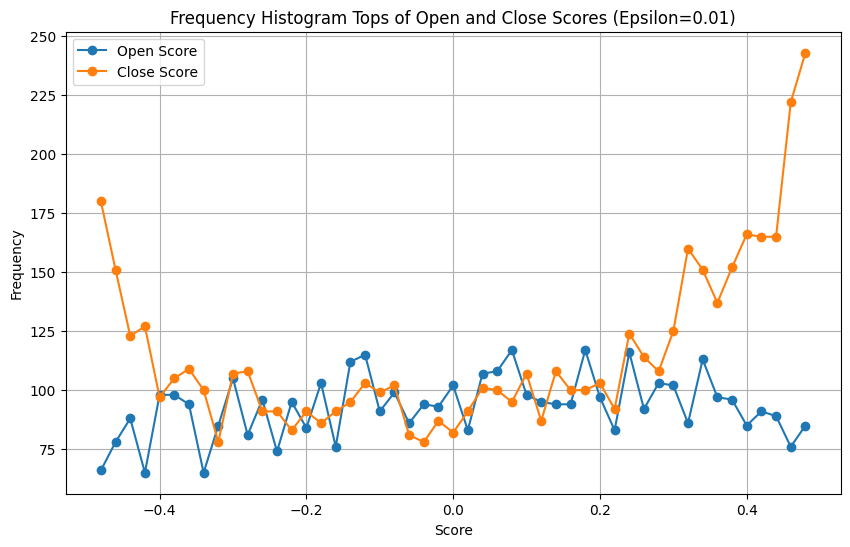

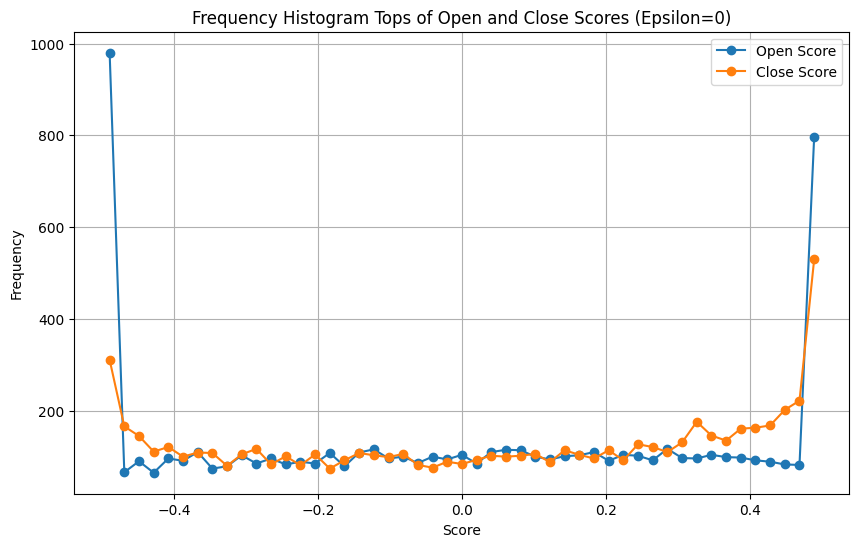

In [48]:
# prompt: Plot the frequency histogram of Open Score together with Close Score, cutting the values higher than 0.5 - epsilon and (-)0.5 + epsilon in the other case, only with top of bars but not the whole histogram column, and when I set epsilon 0, I should be able to see the whole plot

import numpy as np
import matplotlib.pyplot as plt

def plot_score_histogram_tops(df, score_col, title, epsilon=0):
  """
  Plots the top of the frequency histogram for a given score column,
  cutting values based on epsilon.

  Args:
    df: Pandas DataFrame containing the score data.
    score_col: Name of the column containing the scores ('Open Score' or 'Close Score').
    title: Title for the plot.
    epsilon: Epsilon value for cutting the data.
  """
  if epsilon == 0:
    # If epsilon is 0, use all data within the standard range
    filtered_scores = df[score_col].dropna()
    bins = np.linspace(-0.5, 0.5, 50) # Adjust number of bins as needed
  else:
    # Filter scores based on epsilon
    filtered_scores = df[score_col].dropna()
    filtered_scores = filtered_scores[(filtered_scores < 0.5 - epsilon) & (filtered_scores > -0.5 + epsilon)]
    bins = np.linspace(-0.5 + epsilon, 0.5 - epsilon, 50) # Adjust bins based on epsilon

  if filtered_scores.empty:
    print(f"No data to plot for {score_col} with epsilon={epsilon}")
    return

  hist, bin_edges = np.histogram(filtered_scores, bins=bins)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  plt.figure(figsize=(10, 6))
  plt.plot(bin_centers, hist, marker='o', linestyle='-', label=score_col)
  plt.title(title)
  plt.xlabel('Score')
  plt.ylabel('Frequency')
  plt.legend()
  plt.grid(True)
  plt.show()

_="""
# Plotting Open Score
plot_score_histogram_tops(df, 'Open Score', 'Frequency Histogram Tops of Open Score', epsilon=0.01)
plot_score_histogram_tops(df, 'Open Score', 'Frequency Histogram Tops of Open Score (Full)', epsilon=0)

# Plotting Close Score
plot_score_histogram_tops(df, 'Close Score', 'Frequency Histogram Tops of Close Score', epsilon=0.01)
plot_score_histogram_tops(df, 'Close Score', 'Frequency Histogram Tops of Close Score (Full)', epsilon=0)
"""

# To plot both on the same graph, you would need to modify the function
# or plot them manually using subplots or overlaying plots.
# Here's an example of plotting both on the same graph with a fixed epsilon:
def plot_both_scores_histogram_tops(df, epsilon=0):
  """
  Plots the top of the frequency histogram for both Open Score and Close Score.

  Args:
    df: Pandas DataFrame containing the score data.
    epsilon: Epsilon value for cutting the data.
  """
  plt.figure(figsize=(10, 6))

  for score_col in ['Open Score', 'Close Score']:
    if epsilon == 0:
      filtered_scores = df[score_col].dropna()
      bins = np.linspace(-0.5, 0.5, 50)
    else:
      filtered_scores = df[score_col].dropna()
      filtered_scores = filtered_scores[(filtered_scores < 0.5 - epsilon) & (filtered_scores > -0.5 + epsilon)]
      bins = np.linspace(-0.5 + epsilon, 0.5 - epsilon, 50)

    if not filtered_scores.empty:
      hist, bin_edges = np.histogram(filtered_scores, bins=bins)
      bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
      plt.plot(bin_centers, hist, marker='o', linestyle='-', label=score_col)
    else:
        print(f"No data to plot for {score_col} with epsilon={epsilon}")

  plt.title(f'Frequency Histogram Tops of Open and Close Scores (Epsilon={epsilon})')
  plt.xlabel('Score')
  plt.ylabel('Frequency')
  plt.legend()
  plt.grid(True)
  plt.show()

# Plotting both with an epsilon
plot_both_scores_histogram_tops(df, epsilon=0.01)
# Plotting both with epsilon=0 (full range)
plot_both_scores_histogram_tops(df, epsilon=0)

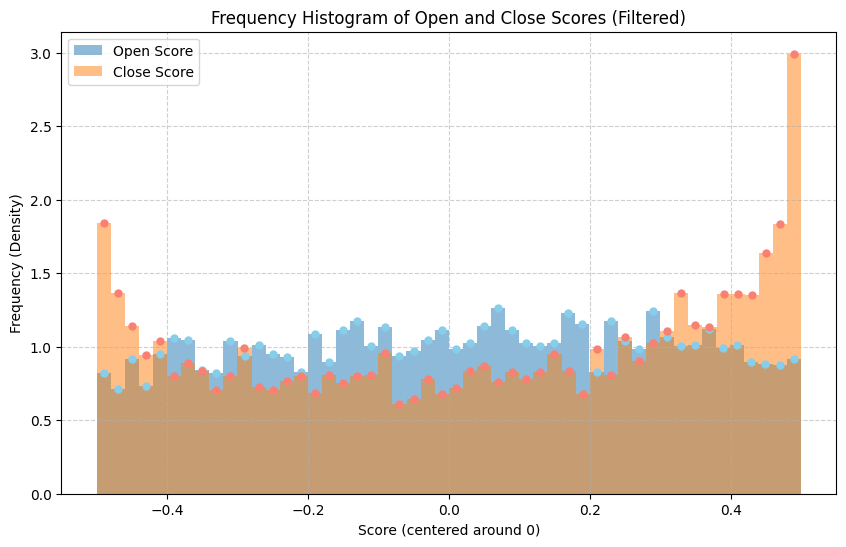

In [43]:
# prompt: Plot the frequency histogram of Open Score together with Close Score, cutting the values higher than 0.5 - epsilon and (-)0.5 + epsilon in the other case, only with top of bars but not the whole histogram column

import numpy as np
import matplotlib.pyplot as plt

# Define epsilon
epsilon = 0

# Filter out values higher than 0.5 - epsilon and lower than -0.5 + epsilon
filtered_open_score = df['Open Score'][(df['Open Score'] < 0.5 - epsilon) & (df['Open Score'] > -0.5 + epsilon)]
filtered_close_score = df['Close Score'][(df['Close Score'] < 0.5 - epsilon) & (df['Close Score'] > -0.5 + epsilon)]

# Plot the frequency histogram with only the top of the bars
plt.figure(figsize=(10, 6))

# Use linestyle 'None' and marker 'o' to show only the top of the bars as points
plt.hist(filtered_open_score, bins=50, alpha=0.5, label='Open Score', histtype='stepfilled', density=True, edgecolor='skyblue', linewidth=0)
plt.hist(filtered_close_score, bins=50, alpha=0.5, label='Close Score', histtype='stepfilled', density=True, edgecolor='salmon', linewidth=0)

# To show only the top of the bars, we need to find the bin centers and heights
open_counts, open_bins = np.histogram(filtered_open_score, bins=50, density=True)
close_counts, close_bins = np.histogram(filtered_close_score, bins=50, density=True)
open_bin_centers = (open_bins[:-1] + open_bins[1:]) / 2
close_bin_centers = (close_bins[:-1] + close_bins[1:]) / 2

plt.plot(open_bin_centers, open_counts, linestyle='None', marker='o', color='skyblue', markersize=5)
plt.plot(close_bin_centers, close_counts, linestyle='None', marker='o', color='salmon', markersize=5)


plt.title('Frequency Histogram of Open and Close Scores (Filtered)')
plt.xlabel('Score (centered around 0)')
plt.ylabel('Frequency (Density)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()